In [19]:
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
import scipy.stats as stats

import warnings
warnings.filterwarnings('ignore')

### Introduction 

In this notebook, we will look at how to use PyMC3 and Bayesian modeling to analyze a biased coin.  Consider the example of flipping a biased coin.  We toss a coin a number of times and record how many heads and tails we get.  Based on the data we record, we are trying to answer whether the coin is fair or not.  

### Theory 

The goal of our analysis will be to generate a posterior distribution for our probabilities.  According to Bayes' theorem, we have the formula:

$p(\theta|y) \propto p(y|\theta)p(\theta)$

so we need to specify which prior and likelihood we will use.  

Assuming that our coin tosses are independent from each other, and assuming only heads and tails are our possible outcomes, we can model the likelihood in Bayes' theorem with a binomial distribution: 

$p(y|\theta) = \frac{N!}{N!(N-y)!}\theta^{y}(1-\theta)^{N-y}$

This is a discrete distribution returning the probability of getting `y` heads out of `N` coin tosses, for a fixed value of $\theta$.  If $\theta$ represents how likely we are to get a head, and we observe that event `y` times, then $(1-\theta)$ must be the chance of getting a tail, which occurs `N-y` times.  If we know $\theta$, the binomial distribution tells us the expected distribution of heads.  Except we don't know this value! So we must specify a prior.  

In this problem, we choose the beta distribution as our prior:

$p(\theta) = \frac{\Gamma(\alpha+\beta)}{\Gamma(\alpha)\Gamma(\beta)}\theta^{\alpha-1}(1-\theta)^{\beta-1}$

Why do we choose a beta distribution for the prior? For one, its distribution is on the interval [0,1], giving it a natural interpretation as a probability.  For another, it is a **conjugate prior**, meaning that when we multiply it by a binomial distribution as a likelihood, our posterior is the **same** form as the prior, a beta distribution.  This makes our analysis much easier.  

### Parameters 

Now let's go ahead and set up the parameters for our analysis.  Since we need to make synthetic data, we will know our true value of $\theta$ ahead of time, which we would obviously not know if this were real data:

In [20]:
# Parameters
np.random.seed(1)
n_experiments = 4
theta_real = 0.25
data = stats.bernoulli.rvs(p=theta_real, size=n_experiments)

### Model Specification 

Before proceeding, we have to specify a model.  We will use a binomial distribution for the likelihood and a beta distribution for the prior with the following parameter values:

$\theta$ ~ $Beta(\alpha, \beta)$

$y$ ~ $Binomial(n=1, p=\theta)$

Multiprocess sampling (2 chains in 2 jobs)
Metropolis: [theta]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 9 seconds.
The number of effective samples is smaller than 25% for some parameters.


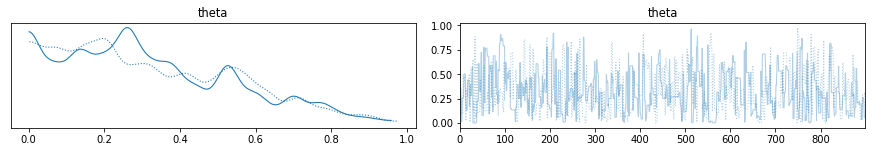

In [21]:
with pm.Model() as coin_flip:
    theta = pm.Beta('theta', alpha=1, beta=1)
    y = pm.Bernoulli('y', p=theta, observed=data)
    
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace = pm.sample(1000, step=step, start=start)
    
    burnin = 100
    chain = trace[burnin:]
    pm.traceplot(chain, lines={'theta': theta_real})

In the above model, there are a few steps we took to make sure our posterior approximation is reasonable.  They are:
- Increase the number of samples.  Here, we use 1000. 
- Remove samples from the beginning of the trace.  This is a "burnin".  We remove the first 100 out of 1000.  This is an ad hoc trick we can use to get a better approximation since MCMC methods take some time when sampling to approximately reach the target distribution.  

PyMC3 allows us to run the model several times in parallel to get a better approximation.  Each chain is independent, so we can use them to check for convergence and for inference.

Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [theta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.
The number of effective samples is smaller than 25% for some parameters.


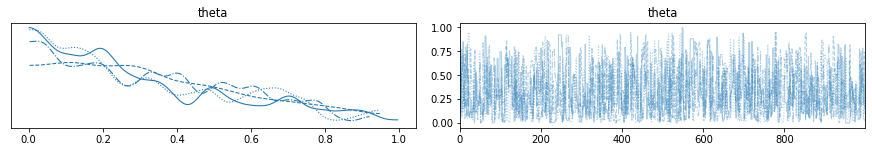

In [22]:
with coin_flip:
    step = pm.Metropolis()
    multi_trace = pm.sample(1000, step=step, cores=4)
    
    burnin = 0
    multi_chain = multi_trace[burnin:]
    pm.traceplot(multi_chain, compact=True, lines={'theta': theta_real})

We can check for convergence using the **Gelman-Rubin test**.  This compares the variance between chaines with the variance within chains.  An ideal value is $\hat{R}$=1.  Higher values than about 1.1 signal a lack of convergence.

In [23]:
# Gelman-Rubin test
pm.summary(multi_chain).round(2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
theta,0.32,0.24,0.0,0.75,0.01,0.0,987.0,986.0,962.0,1047.0,1.0


### Autocorrelation

In a perfect sample, we would have zero autocorrelation.  However, in most MCMC methods, particularly Metropolis-Hastings, autocorrelation is something we usually have to worry about.  Let's check:

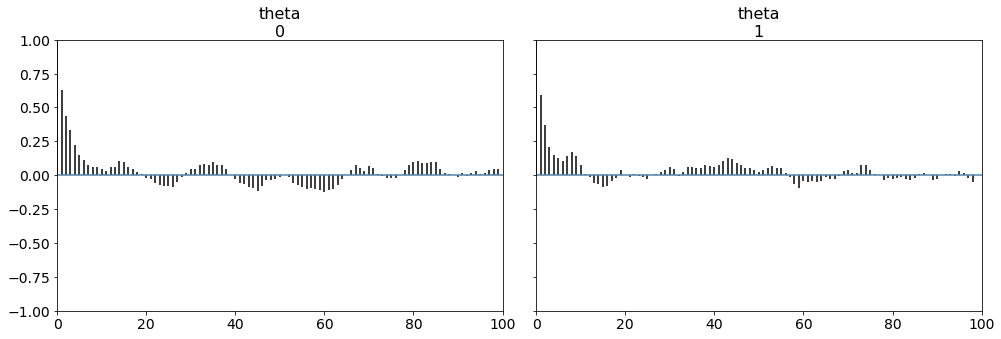

In [25]:
# Autocorrelation
pm.autocorrplot(chain);

The plot shows the average correlation of sample values compared to successive points, with up to 100 points.  The more autocorrelation that a parameter is, the larger the number of samples needed to obtain a given precision.  

### Summarizing the Posterior

Once we have obtained and checked the posterior, now we can visualize it:

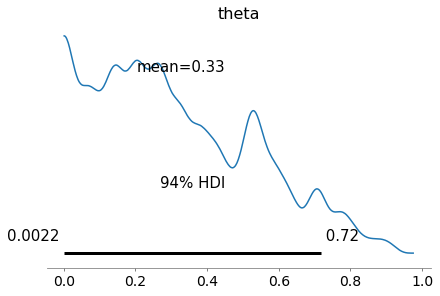

In [31]:
# Visualize the posterior
pm.plot_posterior(chain);